In [2386]:
import numpy as np
import json
import random
import argparse
import os

import torch
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.distributions.multivariate_normal as mvn
from torch.nn.utils import spectral_norm

import torchvision.datasets as datasets
import torchvision.transforms as transforms
from PIL import Image, ImageDraw

In [2387]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [2388]:
seed = 1123
random.seed(seed)
torch.manual_seed(seed)
print("Random Seed: ", seed)

Random Seed:  1123


In [2389]:
# batch_size = args.batch_size
# lrd = args.learning_rate_disc
# lrg = args.learning_rate_gen
# epochs = args.epochs

batch_size = 256
lr = 1e-4
epochs = 10

betas = [0.5, 0.999]

# Check for cuda
use_cuda = torch.cuda.is_available()

EPS = 1e-6

In [2390]:
class Encoder(nn.Module):
    def __init__(self, in_channels = 1, num_hiddens = 128, hidden_dim=64, z=10):
        super(Encoder, self).__init__()

        self.num_hiddens = num_hiddens
        self.z = z

        self._conv_0 = nn.Conv2d(in_channels=in_channels,
                                 out_channels=num_hiddens//4,
                                 kernel_size=4,
                                 stride=2, padding=1)

        self._conv_1 = nn.Conv2d(in_channels=num_hiddens//4,
                                 out_channels=num_hiddens//4,
                                 kernel_size=4,
                                 stride=2, padding=1)


        self._conv_2 = nn.Conv2d(in_channels=num_hiddens//4,
                                 out_channels=num_hiddens//2,
                                 kernel_size=4,
                                 stride=2, padding=1)


        self._conv_3 = nn.Conv2d(in_channels=num_hiddens//2,
                                 out_channels=num_hiddens//2,
                                 kernel_size=4,
                                 stride=2, padding=1)

        self._fc1 = nn.Linear(1024, hidden_dim)

        self.fc_mean = nn.Linear(hidden_dim, self.z)
        self.fc_logvar = nn.Linear(hidden_dim, self.z)
        #self.fc_theta = nn.Linear(hidden_dim, self.z)

    def forward(self, inputs):

        x1 = F.leaky_relu(self._conv_0(inputs), 0.2, inplace=True)

        x2 = self._conv_1(x1)
        x2 = F.leaky_relu(x2, 0.2, inplace=True)

        x3 = self._conv_2(x2)
        x3 = F.leaky_relu(x3, 0.2, inplace=True)

        x4 = self._conv_3(x3)
        x4 = F.leaky_relu(x4, 0.2, inplace=True)

        x5 = self._fc1(x4.view(-1, self.num_hiddens*8))
        x5 = F.leaky_relu(x5, 0.2, inplace=True)

        mean = self.fc_mean(x5)
        logvar = self.fc_logvar(x5)
        return mean, logvar

In [2391]:
class Decoder(nn.Module):
    def __init__(self, latent_dim = 10, hidden_dim = 256, num_hiddens = 128, out_channels=1):
        super(Decoder, self).__init__()

        self.num_hiddens = num_hiddens

        self._fc1 = nn.Linear(latent_dim, hidden_dim//2)

        self._fc2 = nn.Linear(hidden_dim//2, 1024)

        # the exact inverse of the encoder
        self._tconv2 = nn.ConvTranspose2d(num_hiddens//2, num_hiddens//2, kernel_size=4, stride=2, padding =1)

        self._tconv3 = nn.ConvTranspose2d(in_channels=num_hiddens//2,
                                                out_channels=num_hiddens//4,
                                                kernel_size=4,
                                                stride=2, padding=1)

        self._tconv4 = nn.ConvTranspose2d(in_channels=num_hiddens//4,
                                                out_channels=num_hiddens//4,
                                                kernel_size=4,
                                                stride=2, padding=1)


        self._tconv5 = nn.ConvTranspose2d(in_channels=num_hiddens//4,
                                                out_channels=out_channels,
                                                kernel_size=4,
                                                stride=2, padding=1)

    def forward(self, inputs):
        x = self._fc1(inputs)
        x = F.leaky_relu(x, 0.2, inplace=True)

        x = self._fc2(x)
        x = F.leaky_relu(x, 0.2, inplace=True)

        x = self._tconv2(x.view(-1,64,4,4))
        x = F.leaky_relu(x, 0.2, inplace=True)

        x = self._tconv3(x)
        x = F.leaky_relu(x, 0.2, inplace=True)

        x = self._tconv4(x)
        x = F.leaky_relu(x, 0.2, inplace=True)

        return torch.sigmoid(self._tconv5(x))

In [2392]:
class PrototypeEncoder(nn.Module):
    def __init__(self, x_dim=(1,64,64), hid_dim=64, z_dim=2, num_channels=2):
        super(PrototypeEncoder, self).__init__()

        def conv_block(in_channels, out_channels):
            return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, stride=2, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
            )
        self.conv1 = conv_block(num_channels, hid_dim//2)
        self.conv2 = conv_block(hid_dim//2, hid_dim)
        self.conv3 = conv_block(hid_dim, hid_dim*2)
        self.conv4_z = conv_block(hid_dim*2, z_dim)
        self.linear_z = nn.Linear(z_dim*x_dim[-1]//4, z_dim)
        self.linear_c = nn.Linear(z_dim*x_dim[-1]//4, 10)

    def forward(self,x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4_z(x)
        z = self.linear_z(x.view(x.shape[0],-1))
        y = self.linear_c(x.view(x.shape[0],-1))
        return z, y

In [2393]:
class Protonet(nn.Module):
    def __init__(self, encoder):
        super(Protonet, self).__init__()

        self.encoder = encoder

In [2394]:
class VAE(nn.Module):
    def __init__(self, img_size = (1,64,64), enc_hidden = 256, hidden_dim = 64, dis_hidden = 32, z = 5, dec_hidden = 256, use_cuda=False):

        super(VAE, self).__init__()
        self.use_cuda = use_cuda

        # Parameters
        self.img_size = img_size
        self.num_pixels = img_size[0] * img_size[1] * img_size[2]
        self.z = z
        self.channels = img_size[0]

        # Define the encoder
        self.img_to_features = Encoder(in_channels=self.channels, hidden_dim=hidden_dim, z=self.z)

        # Define decoder
        self.features_to_img = Decoder(self.z, out_channels=self.channels)

    def forward(self, data):
        mean, logvar = self.encode(data)
        sample = self.reparameterize([mean, logvar])
        recons = self.decode(mean)
        return recons, [mean, logvar]
    
    def encode(self,data):
        return self.img_to_features(data)
    
    def decode(self,data):
        return self.features_to_img(data)
        
    def representation_function(self,x):
        mean, logvar = self.img_to_features(x)
        return mean

    def reparameterize(self, latent_disc):
        mean, logvar = latent_disc
        std = torch.exp(0.5 * logvar)
        eps = torch.zeros(std.size()).normal_()
        if self.use_cuda:
            eps = eps.cuda()
        return mean + std * eps

In [2395]:
if __name__ == "__main__":
    batch_size = 256
    img_size = (3,64,64)
    z=10
    model = VAE(img_size=img_size, z=z, use_cuda=use_cuda)
    model.img_to_features.register_buffer('kl', torch.zeros(10))
    #model.img_to_features.register_buffer('prototypes', torch.zeros(5,3))
    
    #model.img_to_features.register_buffer('old_kl', torch.zeros(10))
    
    if use_cuda:
        model.cuda()
    checkpoint = torch.load('onecosklprotorealfrwrweights_e500_z10_b1_g0_lr[0.0001, 0.0001, 0.0001]_bs128_s1123_r[10, 10, 10, 10, True]_d4',map_location=torch.device('cpu'))
    plots = ['samples', 'reconstruct-traverse']
    loss_file = 'onecosklprotorealfrwrlosses_e500_z10_b1_g0_lr[0.0001, 0.0001, 0.0001]_bs128_s1123_r[10, 10, 10, 10, True]_d4.json'
    
    prototype = PrototypeEncoder(x_dim=img_size,hid_dim=64, z_dim=2, num_channels=2*img_size[0])
    protonet = Protonet(prototype)
    
    #

In [2396]:
test_data = torch.from_numpy(np.load('../3dshapes/3dshapes_data_fr_wr.npy')).permute(0,3,1,2).float()
test_labels = torch.from_numpy(np.load('../3dshapes/3dshapes_labels_fr_wr.npy')).float()

# test_data = torch.from_numpy(np.load('../3dshapes/3dshapes_test_images.npy')).permute(0,3,1,2).float()
# test_labels = torch.from_numpy(np.load('../3dshapes/3dshapes_test_labels.npy')).float()

test_dataset = torch.utils.data.TensorDataset(test_data,test_labels)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 64, shuffle=True,
drop_last=True)

print(len(test_loader.dataset))

4800


In [2397]:
################## yann visualizations ########################################

In [2398]:
class Visualizer():
    def __init__(self, model, model_dir, loss_file, 
                 save_images=True,
                 loss_of_interest=None,
                 display_loss_per_dim=False,
                 max_traversal=0.475,  # corresponds to ~2 for standard normal
                 upsample_factor=1):
        """
        Visualizer is used to generate images of samples, reconstructions,
        latent traversals and so on of the trained model.
        Parameters
        ----------
        model : disvae.vae.VAE
        dataset : str
            Name of the dataset.
        model_dir : str
            The directory that the model is saved to and where the images will
            be stored.
        save_images : bool, optional
            Whether to save images or return a tensor.
        loss_of_interest : str, optional
            The loss type (as saved in the log file) to order the latent dimensions by and display.
        display_loss_per_dim : bool, optional
            if the loss should be included as text next to the corresponding latent dimension images.
        max_traversal: float, optional
            The maximum displacement induced by a latent traversal. Symmetrical
            traversals are assumed. If `m>=0.5` then uses absolute value traversal,
            if `m<0.5` uses a percentage of the distribution (quantile).
            E.g. for the prior the distribution is a standard normal so `m=0.45` c
            orresponds to an absolute value of `1.645` because `2m=90%%` of a
            standard normal is between `-1.645` and `1.645`. Note in the case
            of the posterior, the distribution is not standard normal anymore.
        upsample_factor : floar, optional
            Scale factor to upsample the size of the tensor
        """
        self.model = model
        self.device = next(self.model.parameters()).device
        self.latent_dim = self.model.z
        self.max_traversal = max_traversal
        self.save_images = save_images
        self.model_dir = model_dir 
        self.dataset = 'dsprites'
        self.upsample_factor = upsample_factor
        if loss_of_interest is not None:
            # get this from your loss file
            self.losses = read_loss_from_file(loss_file)

    def _get_traversal_range(self, mean=0, std=1):
        """Return the corresponding traversal range in absolute terms."""
        max_traversal = self.max_traversal

        if max_traversal < 0.5:
            max_traversal = (1 - 2 * max_traversal) / 2  # from 0.45 to 0.05
            max_traversal = stats.norm.ppf(max_traversal, loc=mean, scale=std)  # from 0.05 to -1.645

        # symmetrical traversals
        return (-1 * max_traversal, max_traversal)

    def _traverse_line(self, idx, n_samples, data=None):
        """Return a (size, latent_size) latent sample, corresponding to a traversal
        of a latent variable indicated by idx.
        Parameters
        ----------
        idx : int
            Index of continuous dimension to traverse. If the continuous latent
            vector is 10 dimensional and idx = 7, then the 7th dimension
            will be traversed while all others are fixed.
        n_samples : int
            Number of samples to generate.
        data : torch.Tensor or None, optional
            Data to use for computing the posterior. Shape (N, C, H, W). If
            `None` then use the mean of the prior (all zeros) for all other dimensions.
        """
        if data is None:
            # mean of prior for other dimensions
            samples = torch.zeros(n_samples, self.latent_dim)
            traversals = torch.linspace(*self._get_traversal_range(), steps=n_samples)

        else:
            if data.size(0) > 1:
                raise ValueError("Every value should be sampled from the same posterior, but {} datapoints given.".format(data.size(0)))

            with torch.no_grad():
                post_mean, post_logvar = self.model.encode(data.to(self.device))
                samples = self.model.reparameterize([post_mean, post_logvar])
                samples = samples.cpu().repeat(n_samples, 1)
                post_mean_idx = post_mean.cpu()[0, idx]
                post_std_idx = torch.exp(post_logvar / 2).cpu()[0, idx]

            # travers from the gaussian of the posterior in case quantile
            traversals = torch.linspace(*self._get_traversal_range(mean=post_mean_idx,
                                                                   std=post_std_idx),
                                        steps=n_samples)

        for i in range(n_samples):
            samples[i, idx] = traversals[i]

        return samples

    def _save_or_return(self, to_plot, size, filename, is_force_return=False):
        """Create plot and save or return it."""
        to_plot = F.interpolate(to_plot, scale_factor=self.upsample_factor)

        if size[0] * size[1] != to_plot.shape[0]:
            raise ValueError("Wrong size {} for datashape {}".format(size, to_plot.shape))

        # `nrow` is number of images PER row => number of col
        kwargs = dict(nrow=size[1], pad_value=1)
        if self.save_images and not is_force_return:
            filename = os.path.join(self.model_dir, filename)
            save_image(to_plot, filename, **kwargs)
        else:
            return make_grid_img(to_plot, **kwargs)

    def _decode_latents(self, latent_samples):
        """Decodes latent samples into images.
        Parameters
        ----------
        latent_samples : torch.autograd.Variable
            Samples from latent distribution. Shape (N, L) where L is dimension
            of latent distribution.
        """
        latent_samples = latent_samples.to(self.device)
        return self.model.decode(latent_samples).cpu()

    def generate_samples(self, size=(8, 8)):
        """Plot generated samples from the prior and decoding.
        Parameters
        ----------
        size : tuple of ints, optional
            Size of the final grid.
        """
        prior_samples = torch.randn(size[0] * size[1], self.latent_dim)
        generated = self._decode_latents(prior_samples)
        return self._save_or_return(generated.data, size, PLOT_NAMES["generate_samples"])

    def data_samples(self, data, size=(8, 8)):
        """Plot samples from the dataset
        Parameters
        ----------
        data : torch.Tensor
            Data to be reconstructed. Shape (N, C, H, W)
        size : tuple of ints, optional
            Size of the final grid.
        """
        data = data[:size[0] * size[1], ...]
        return self._save_or_return(data, size, PLOT_NAMES["data_samples"])

    def reconstruct(self, data, size=(8, 8), is_original=True, is_force_return=False):
        """Generate reconstructions of data through the model.
        Parameters
        ----------
        data : torch.Tensor
            Data to be reconstructed. Shape (N, C, H, W)
        size : tuple of ints, optional
            Size of grid on which reconstructions will be plotted. The number
            of rows should be even when `is_original`, so that upper
            half contains true data and bottom half contains reconstructions.contains
        is_original : bool, optional
            Whether to exclude the original plots.
        is_force_return : bool, optional
            Force returning instead of saving the image.
        """
        if is_original:
            if size[0] % 2 != 0:
                raise ValueError("Should be even number of rows when showing originals not {}".format(size[0]))
            n_samples = size[0] // 2 * size[1]
        else:
            n_samples = size[0] * size[1]

        with torch.no_grad():
            originals = data.to(self.device)[:n_samples, ...]
            recs,_ = self.model(originals)

        originals = originals.cpu()
        recs = recs.view(-1, *self.model.img_size).cpu()

        to_plot = torch.cat([originals, recs]) if is_original else recs
        return self._save_or_return(to_plot, size, PLOT_NAMES["reconstruct"],
                                    is_force_return=is_force_return)

    def traversals(self,
                   data=None,
                   is_reorder_latents=False,
                   n_per_latent=8,
                   n_latents=None,
                   is_force_return=False):
        """Plot traverse through all latent dimensions (prior or posterior) one
        by one and plots a grid of images where each row corresponds to a latent
        traversal of one latent dimension.
        Parameters
        ----------
        data : bool, optional
            Data to use for computing the latent posterior. If `None` traverses
            the prior.
        n_per_latent : int, optional
            The number of points to include in the traversal of a latent dimension.
            I.e. number of columns.
        n_latents : int, optional
            The number of latent dimensions to display. I.e. number of rows. If `None`
            uses all latents.
        is_reorder_latents : bool, optional
            If the latent dimensions should be reordered or not
        is_force_return : bool, optional
            Force returning instead of saving the image.
        """
        n_latents = n_latents if n_latents is not None else self.model.latent_dim
        latent_samples = [self._traverse_line(dim, n_per_latent, data=data)
                          for dim in range(self.latent_dim)]
        
        # change one line here
        lats = torch.cat(latent_samples, dim=0) #*torch.tensor([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0]).view(1, 10)
        
        decoded_traversal = self._decode_latents(lats)

        if is_reorder_latents:
            n_images, *other_shape = decoded_traversal.size()
            n_rows = n_images // n_per_latent
            decoded_traversal = decoded_traversal.reshape(n_rows, n_per_latent, *other_shape)
            decoded_traversal = sort_list_by_other(decoded_traversal, self.losses)
            decoded_traversal = torch.stack(decoded_traversal, dim=0)
            decoded_traversal = decoded_traversal.reshape(n_images, *other_shape)
            
        decoded_traversal = decoded_traversal[range(n_per_latent * n_latents), ...]

        size = (n_latents, n_per_latent)
        sampling_type = "prior" if data is None else "posterior"
        filename = "{}_{}".format(sampling_type, PLOT_NAMES["traversals"])

        return self._save_or_return(decoded_traversal.data, size, filename,
                                    is_force_return=is_force_return)

    def reconstruct_traverse(self, data,
                             is_posterior=True,
                             n_per_latent=10,
                             n_latents=None,
                             is_show_text=True):
        """
        Creates a figure whith first row for original images, second are
        reconstructions, rest are traversals (prior or posterior) of the latent
        dimensions.
        Parameters
        ----------
        data : torch.Tensor
            Data to be reconstructed. Shape (N, C, H, W)
        n_per_latent : int, optional
            The number of points to include in the traversal of a latent dimension.
            I.e. number of columns.
        n_latents : int, optional
            The number of latent dimensions to display. I.e. number of rows. If `None`
            uses all latents.
        is_posterior : bool, optional
            Whether to sample from the posterior.
        is_show_text : bool, optional
            Whether the KL values next to the traversal rows.
        """
        n_latents = n_latents if n_latents is not None else self.model.latent_dim

        reconstructions = self.reconstruct(data[:2 * n_per_latent, ...],
                                           size=(2, n_per_latent),
                                           is_force_return=True)
        traversals = self.traversals(data=data[3:4, ...] if is_posterior else None,
                                     is_reorder_latents=True,
                                     n_per_latent=n_per_latent,
                                     n_latents=n_latents,
                                     is_force_return=True)

        concatenated = np.concatenate((reconstructions, traversals), axis=0)
        concatenated = Image.fromarray(concatenated)
        concatenated.show()

        if is_show_text:
            losses = sorted(self.losses, reverse=True)[:n_latents]
            labels = ['orig', 'recon'] + ["KL={:.4f}".format(l) for l in losses]
            concatenated = add_labels(concatenated, labels)

        filename = os.path.join(self.model_dir, PLOT_NAMES["reconstruct_traverse"])
        concatenated.save(filename)

In [2399]:
def load_weights(model, checkpoint):
    model.img_to_features.load_state_dict(checkpoint['encoder'])
    model.features_to_img.load_state_dict(checkpoint['decoder'])
    model.eval()
    return model

def make_grid_img(tensor, **kwargs):
    """Converts a tensor to a grid of images that can be read by imageio.
    Notes
    -----
    * from in https://github.com/pytorch/vision/blob/master/torchvision/utils.py
    Parameters
    ----------
    tensor (torch.Tensor or list): 4D mini-batch Tensor of shape (B x C x H x W)
        or a list of images all of the same size.
    kwargs:
        Additional arguments to `make_grid_img`.
    """
    grid = make_grid(tensor, **kwargs)
    img_grid = grid.mul_(255).add_(0.5).clamp_(0, 255).permute(1, 2, 0)
    img_grid = img_grid.to('cpu', torch.uint8).numpy()
    return img_grid


# def get_samples
def get_samples(dataset, num_samples, idcs=[]):
    """ Generate a number of samples from the dataset.
    Parameters
    ----------
    dataset : str
        The name of the dataset.
    num_samples : int, optional
        The number of samples to load from the dataset
    idcs : list of ints, optional
        List of indices to of images to put at the begning of the samples.
    """
    data_loader = torch.utils.data.DataLoader(dataset,
                                  batch_size=1,
                                  shuffle=idcs is None)

    idcs += random.sample(range(len(data_loader.dataset)), num_samples - len(idcs))
    samples = torch.stack([data_loader.dataset[i][0] for i in idcs], dim=0)
    print("Selected idcs: {}".format(idcs))

    return samples

def sort_list_by_other(to_sort, other, reverse=True):
    """Sort a list by an other."""
    return [el for _, el in sorted(zip(other, to_sort), reverse=reverse)]

def read_loss_from_file(loss_file):
    with open(loss_file) as f:
        data = json.load(f)
    kllist =[]
    for key in list(data):
        if 'kl_' in key:
            if 'kl_z' not in key:
                kllist.append(np.sum(data[key][-100:])/100)
    return kllist

def add_labels(input_image, labels):
    """Adds labels next to rows of an image.
    Parameters
    ----------
    input_image : image
        The image to which to add the labels
    labels : list
        The list of labels to plot
    """
    new_width = input_image.width + 100
    new_size = (new_width, input_image.height)
    new_img = Image.new("RGB", new_size, color='white')
    new_img.paste(input_image, (0, 0))
    draw = ImageDraw.Draw(new_img)

    for i, s in enumerate(labels):
        draw.text(xy=(new_width - 100 + 0.005,
                      int((i / len(labels) + 1 / (2 * len(labels))) * input_image.height)),
                  text=s,
                  fill=(0, 0, 0))

    return new_img

In [2400]:
PLOT_NAMES = dict(generate_samples="samples.png",
                  data_samples="data_samples.png",
                  reconstruct="reconstruct.png",
                  traversals="traversals.png",
                  reconstruct_traverse="reconstruct_traverse.png")
n_rows = z
#n_rows = model.latent_dim
n_cols = 10

#model = VAE(img_size=img_size, z1=2, z2=10, use_cuda=use_cuda)
model = load_weights(model, checkpoint)


dataset = 'dsprites'
    
viz = Visualizer(model=model,
                 model_dir='',
                 max_traversal=2,
                 loss_of_interest='kl_loss', loss_file=loss_file,
                 upsample_factor=1) 
size = (n_rows, n_cols)
# same samples for all plots: sample max then take first `x`data  for all plots
num_samples = n_cols * n_rows
    
samples = get_samples(test_dataset, num_samples)
    
if "all" in plots:
    plots = [p for p in PLOT_TYPES if p != "all"]

# mostly call it with reconstruct-traverse

for plot_type in plots:
    if plot_type == 'generate-samples':
        viz.generate_samples(size=size)
    elif plot_type == 'data-samples':
        viz.data_samples(samples, size=size)
    elif plot_type == "reconstruct":
        viz.reconstruct(samples, size=size)
    elif plot_type == "reconstruct-traverse":
        viz.reconstruct_traverse(samples,
                                 is_posterior=True,
                                 n_latents=n_rows,
                                 n_per_latent=n_cols,
                                 is_show_text=True)

Selected idcs: [2295, 2483, 4581, 4180, 120, 4142, 370, 3792, 2390, 297, 569, 1313, 3972, 42, 39, 1769, 2652, 3789, 3719, 4609, 2909, 3523, 1905, 3954, 158, 3278, 522, 2225, 3150, 2663, 2111, 3662, 3993, 2281, 1363, 848, 795, 2545, 181, 2360, 1456, 1917, 4769, 4651, 3640, 3194, 2213, 3059, 4042, 1172, 1688, 1872, 2984, 1166, 29, 4623, 4100, 4378, 1165, 510, 3289, 1098, 3220, 651, 1237, 4110, 3546, 3395, 3354, 3294, 4401, 4309, 1964, 4425, 2104, 1756, 4537, 1058, 1096, 602, 255, 4638, 3777, 4520, 4728, 819, 2129, 3811, 671, 3155, 2478, 911, 3424, 2799, 676, 1609, 4171, 946, 4184, 2568]


In [2401]:
##### end yann visualizations ##############################################################

In [2402]:
import torchvision.utils as vutils
import matplotlib.pyplot as plt

model.img_to_features.load_state_dict(checkpoint['encoder'])
model.features_to_img.load_state_dict(checkpoint['decoder'])
#protonet.load_state_dict(checkpoint['proto'])

model.eval()

(valid_originals, labels) = next(iter(test_loader))
valid_originals = valid_originals.to(device)
latent_dist = model.encode(valid_originals)
latent_sample = latent_dist[0]
valid_reconstructions = model.decode(latent_sample)

In [2403]:
# c = 0
# import matplotlib.pyplot as plt
# plt.scatter(latent_dist[c][0].detach().numpy(), latent_dist[c][1].detach().numpy()) 
# #             c = labels[:,0,5].detach().numpy().tolist())
# # plt.scatter(latent_dist[c][1].detach().numpy(), np.zeros((32,)), 
# #             c = labels[:,0,5].detach().numpy().tolist())

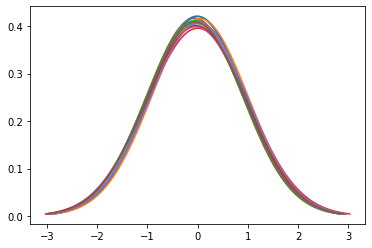

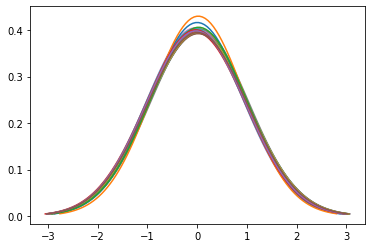

In [2404]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math


lat=4
for i in range(16):
    mu = latent_dist[0][i,lat].detach().numpy()
    variance = latent_dist[1][i,lat].exp().detach().numpy()
    sigma = math.sqrt(variance)
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    #plt.xlim([-2,2])
    plt.plot(x, stats.norm.pdf(x, mu, sigma))#, c = (labels[i,5].detach().numpy().tolist(),0.2,0.5))
plt.show()
lat=5
for i in range(16):
    mu = latent_dist[0][i,lat].detach().numpy()
    variance = latent_dist[1][i,lat].exp().detach().numpy()
    sigma = math.sqrt(variance)
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    plt.plot(x, stats.norm.pdf(x, mu, sigma))#, c = (labels[i,3].detach().numpy().tolist(),0.2,0.5))
plt.show()

In [2405]:
# print(latent_dist[1])

In [2406]:
def show_images_grid(imgs_, num_images=64):
    imgs_ = imgs_.numpy()
    #ncols = int(np.ceil(num_images**0.5))
    #nrows = int(np.ceil(num_images / ncols))
    ncols=10
    nrows=10
    _, axes = plt.subplots(ncols, nrows, figsize=(nrows * 3, ncols * 3))
    axes = axes.flatten()

    for ax_i, ax in enumerate(axes):
        if ax_i < num_images:
            ax.imshow(imgs_[ax_i], cmap='Greys_r', interpolation='nearest')
            ax.set_xticks([])
            ax.set_yticks([])
        else:
            ax.axis('off')

In [2407]:
# samp = latent_sample[3]
# s = samp.repeat(40,1)

# b = torch.linspace(-2,2,40)
# s[:,9] = b.view(40,)
# show(vutils.make_grid(model.decode(s).cpu().data, pad_value=1,nrow=10))

## s = samp.repeat(10,1)

b = torch.linspace(-1,2,10)
s[:,9] = b.view(10,)
show(vutils.make_grid(model.decode(s).cpu().data, pad_value=1,nrow=10))

In [2408]:
# s = samp.repeat(40,1)
# s[:,4] = b.view(40,)
# show(vutils.make_grid(model.decode(s).cpu().data, pad_value=1))

In [2409]:
# s = samp.repeat(40,1)
# s[:,7] = b.view(40,)
# show(vutils.make_grid(model.decode(s).cpu().data, pad_value=1))

In [2410]:
# s = samp.repeat(40,1)
# s[:,9] = b.view(40,)
# show(vutils.make_grid(model.decode(s).cpu().data, pad_value=1))

In [2411]:
# import matplotlib.pyplot as plt
# lis = test_labels.detach().numpy()[:,-1].tolist()
# liss = [x/32 for x in lis]
# plt.scatter(latent_dist[0].detach().numpy(), np.zeros((32,)), 
#             c = liss)

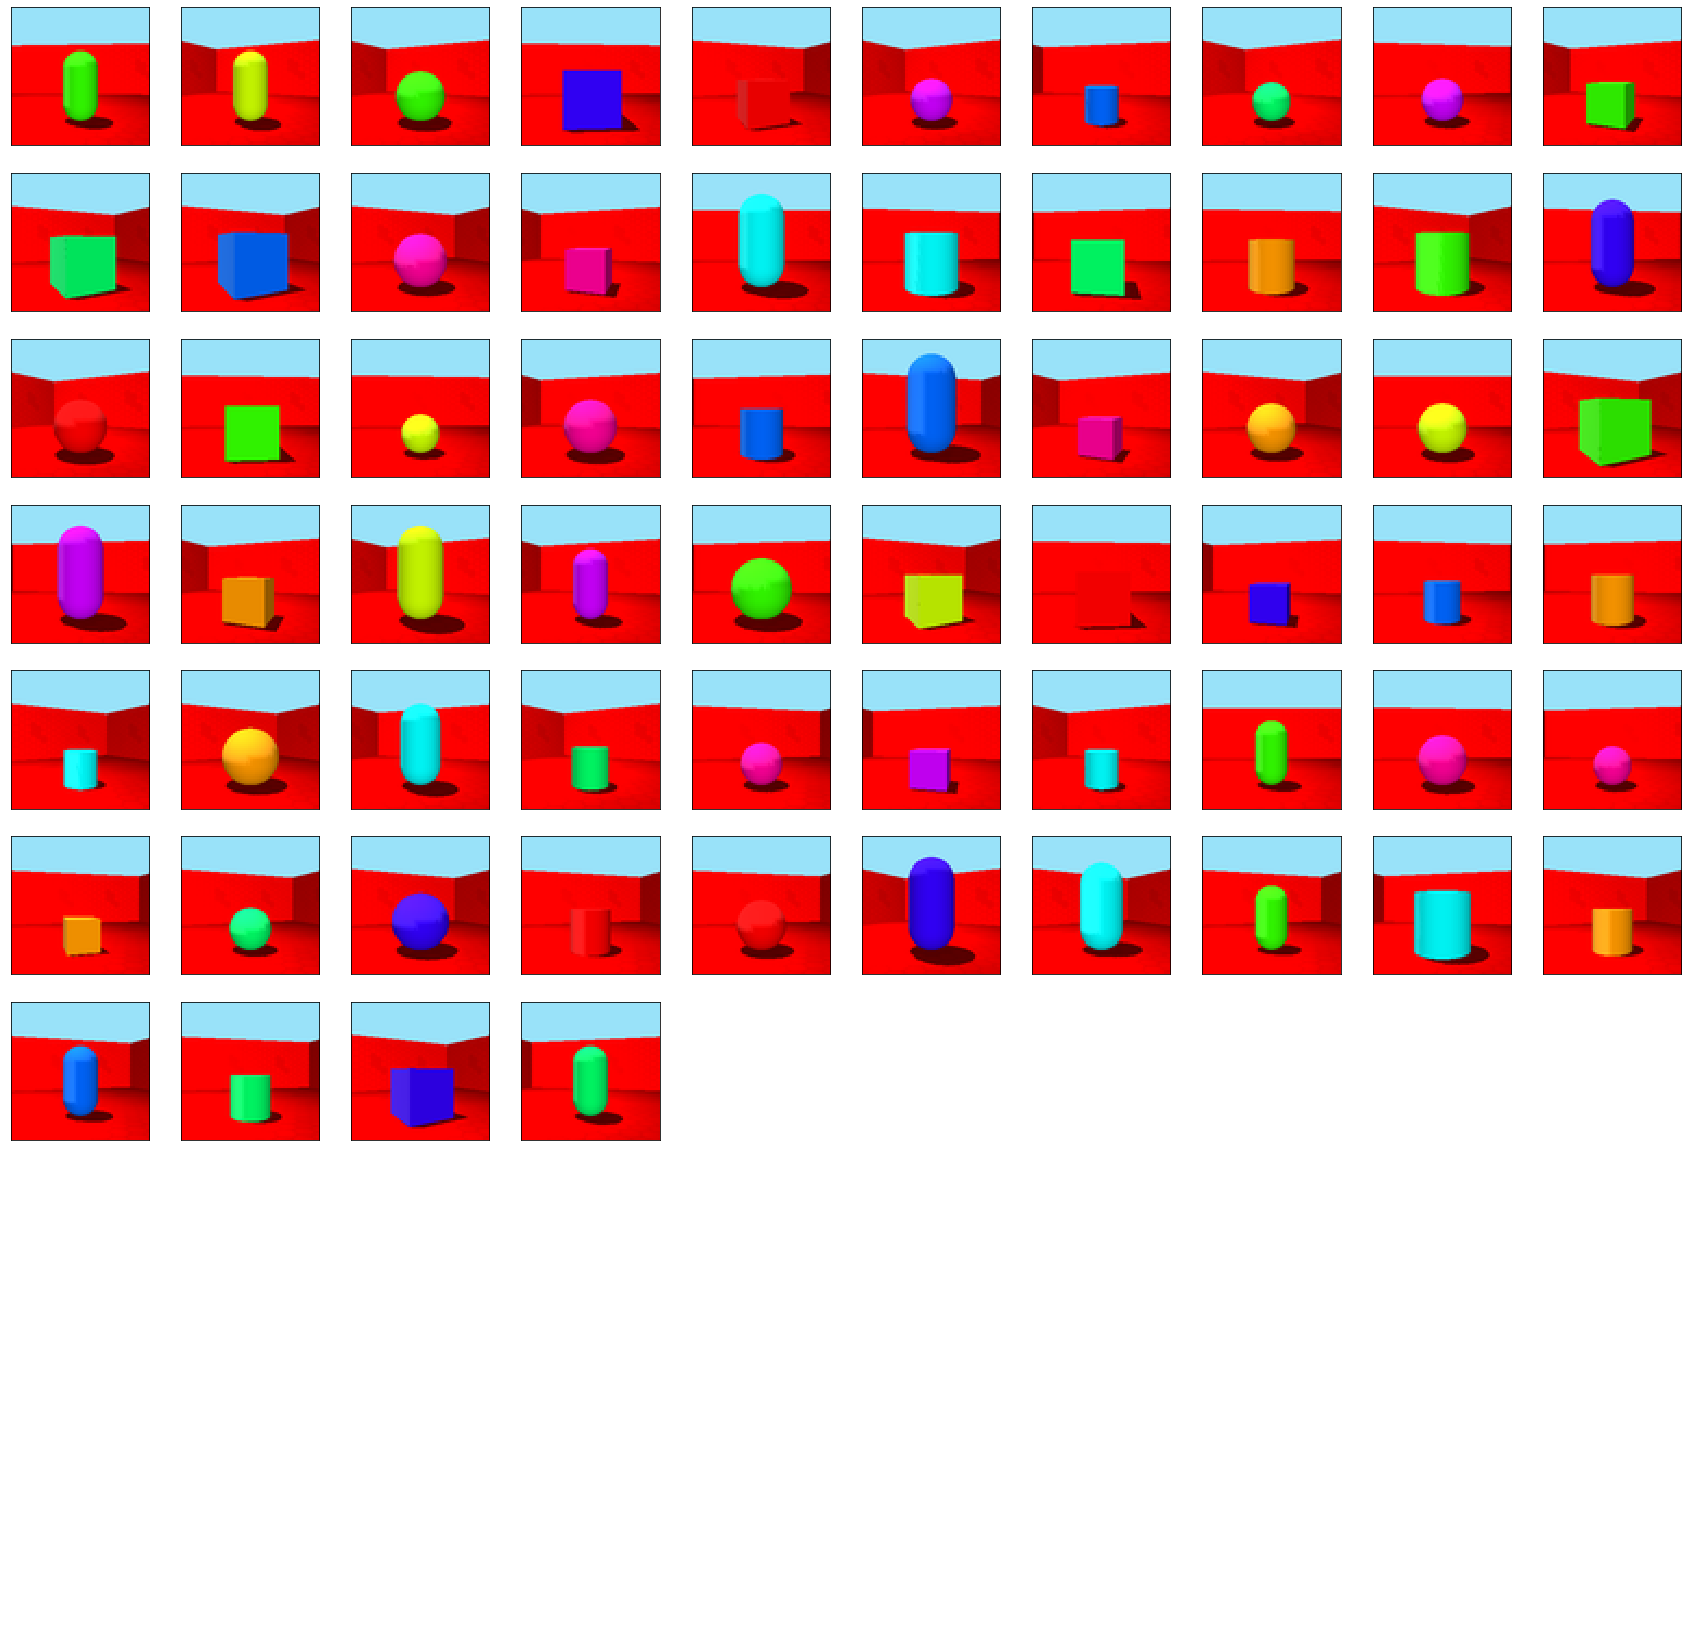

In [2412]:
show_images_grid(valid_originals.permute(0,2,3,1).cpu().data)

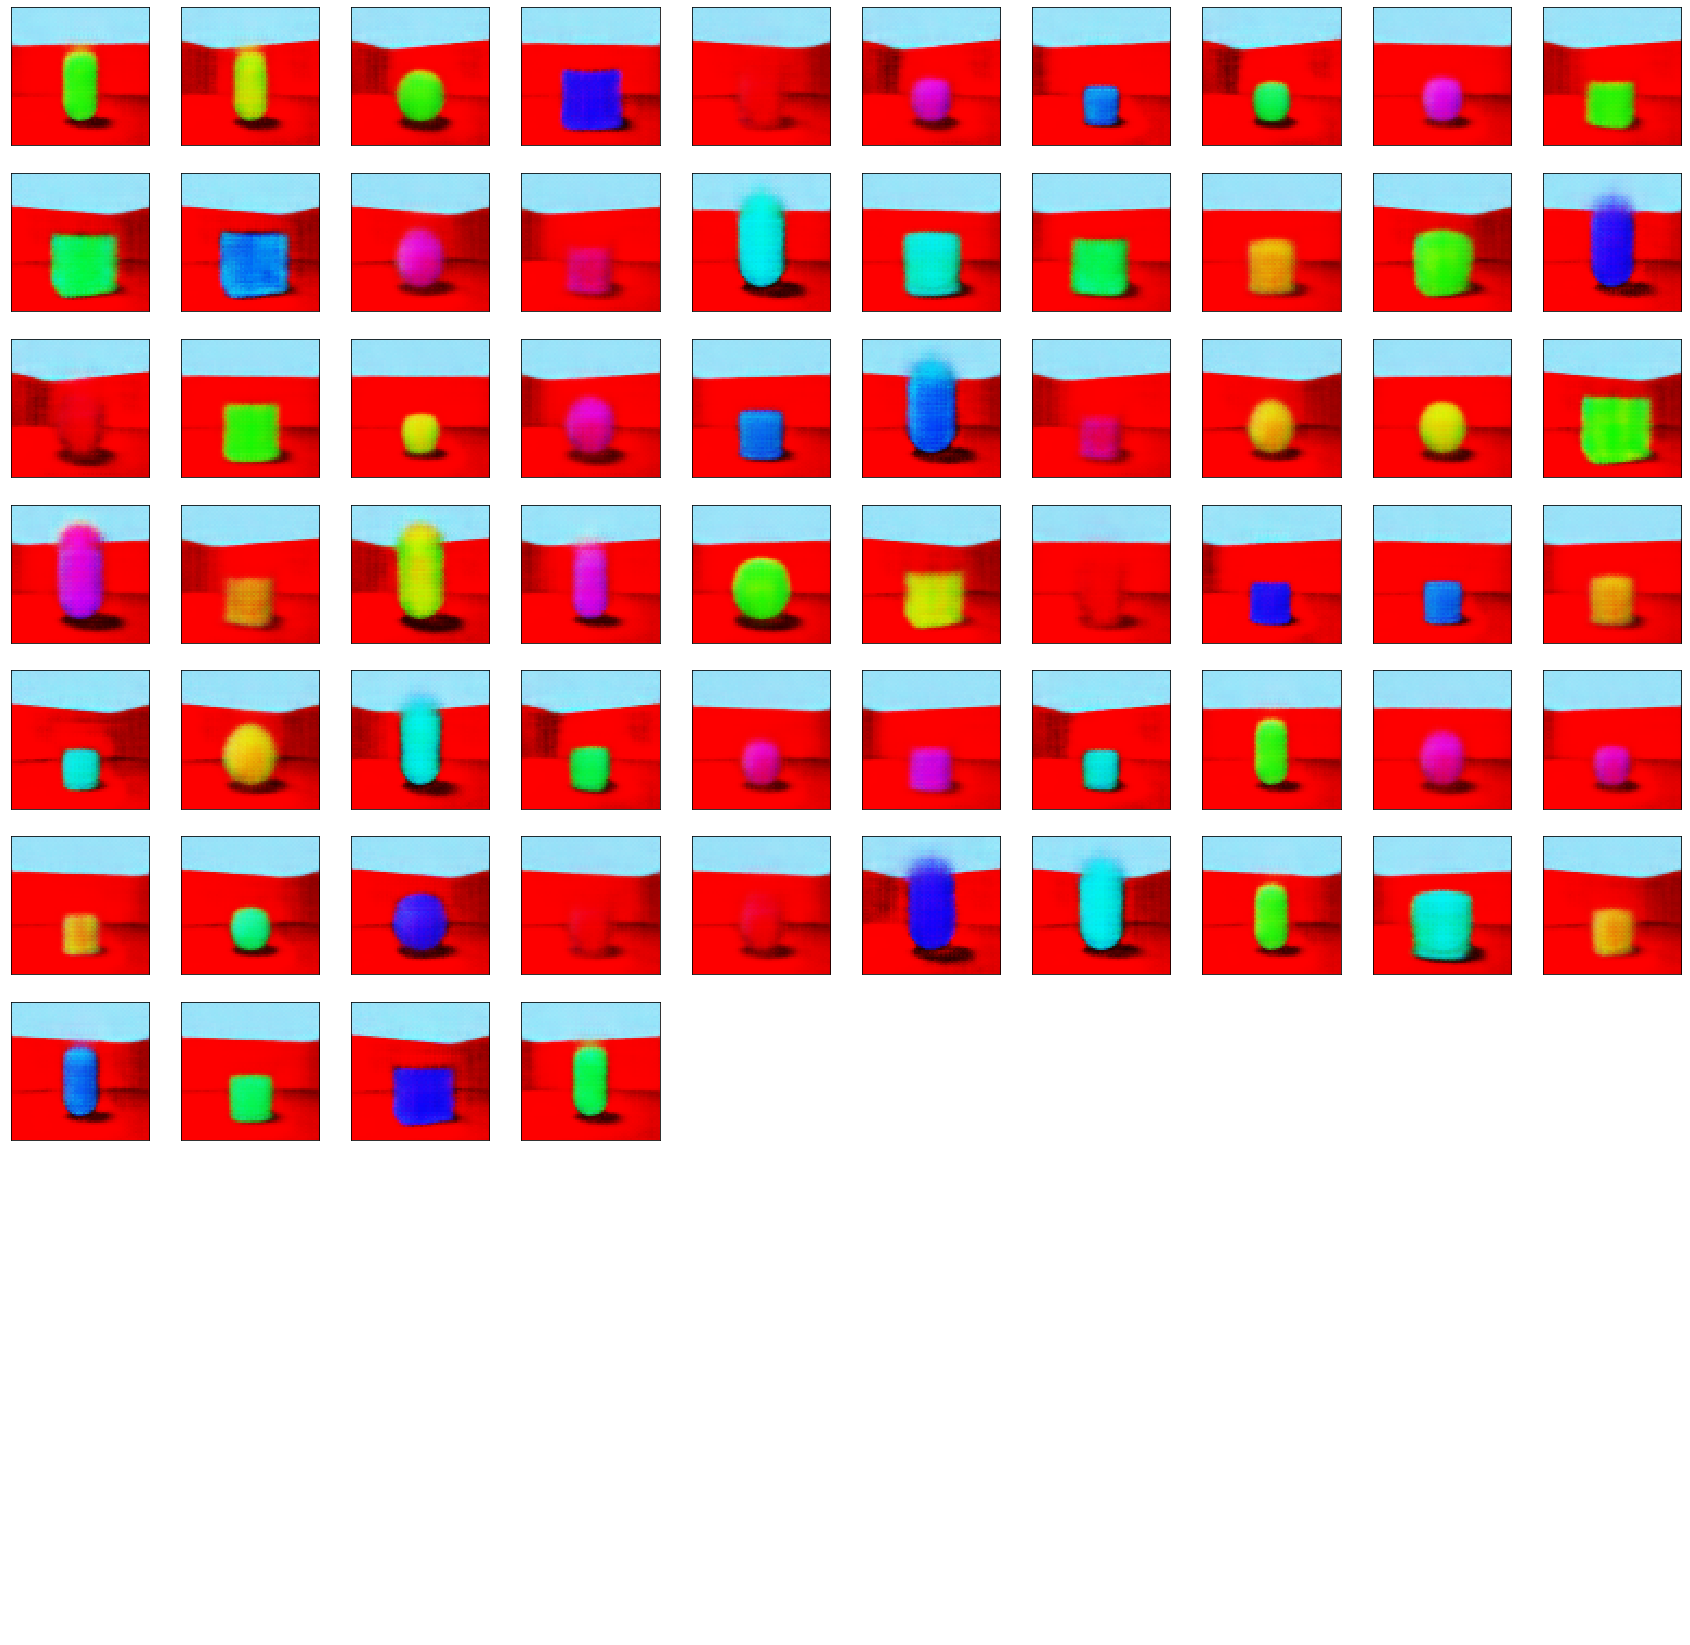

In [2413]:
show_images_grid(valid_reconstructions.permute(0,2,3,1).cpu().data)

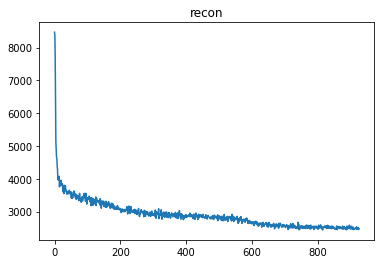

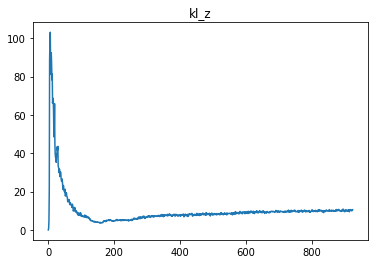

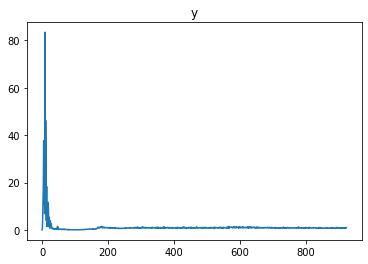

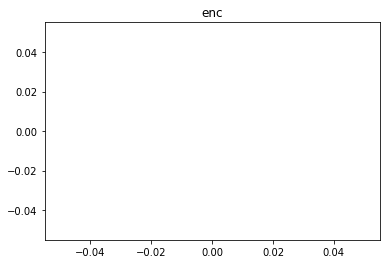

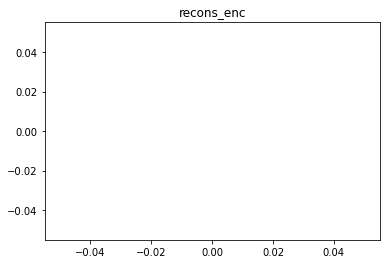

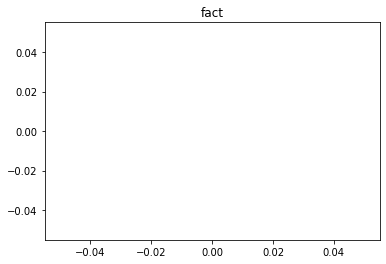

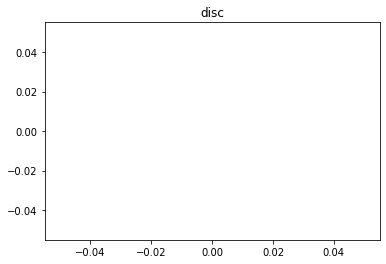

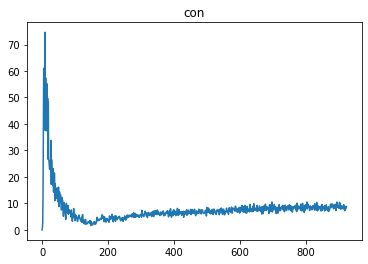

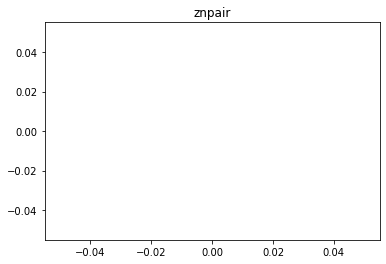

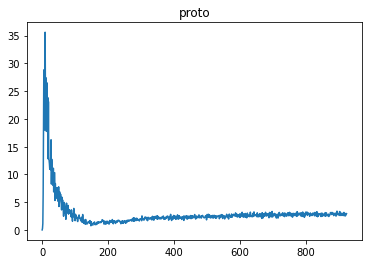

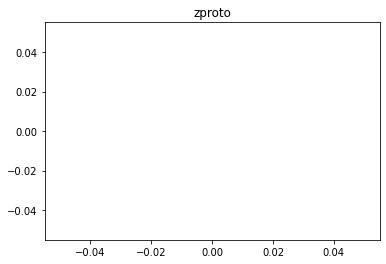

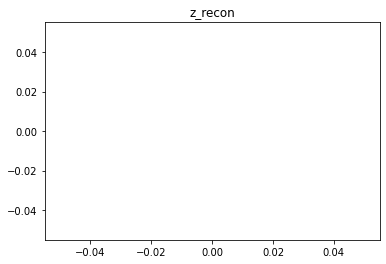

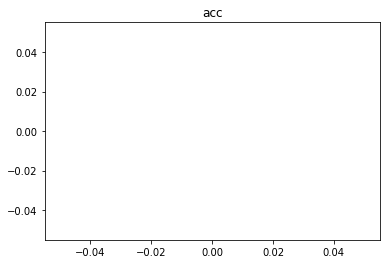

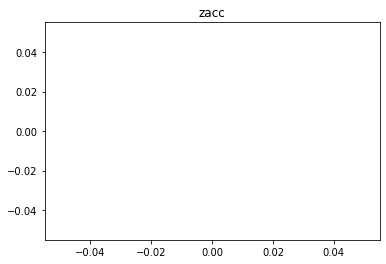

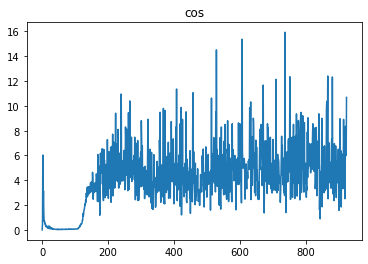

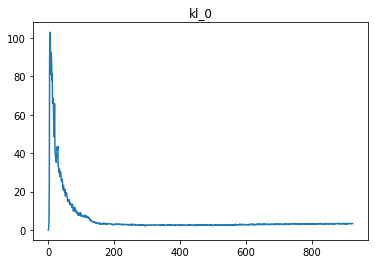

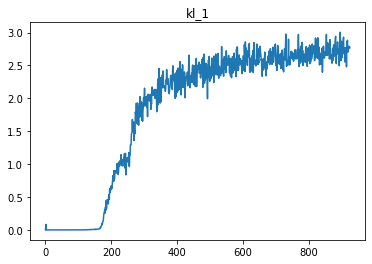

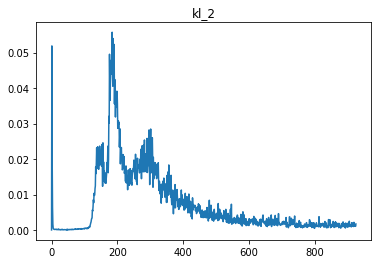

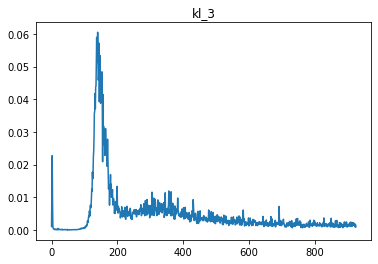

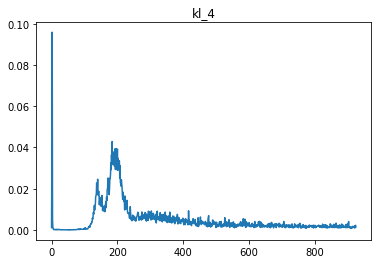

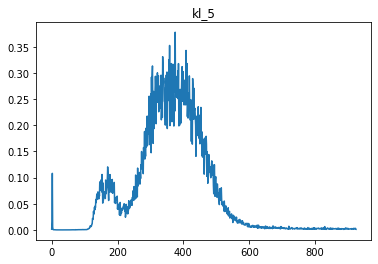

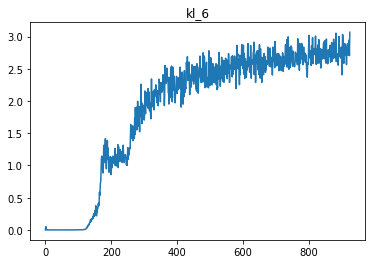

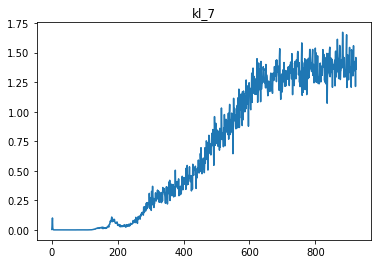

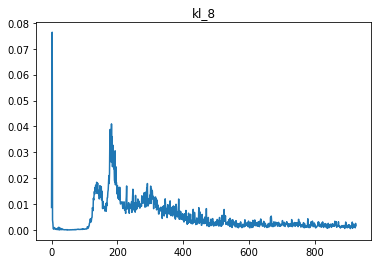

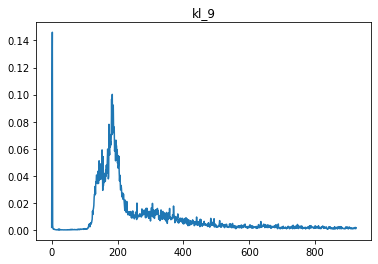

In [2414]:
import json
import matplotlib.pyplot as plt

with open(loss_file) as f:
    data = json.load(f)

for key in list(data):
    plt.plot(data[key][:])
    plt.title(key)
    plt.show()

In [2415]:
from matplotlib import pyplot as plt
import numpy as np
import h5py

In [2416]:
# get the shapes dataset
# load dataset
dataset = h5py.File('../3dshapes/3dshapes.h5', 'r')
print(dataset.keys())
images = dataset['images']  # array shape [480000,64,64,3], uint8 in range(256)
labels = dataset['labels']  # array shape [480000,6], float64
image_shape = images.shape[1:]  # [64,64,3]
label_shape = labels.shape[1:]  # [6]
n_samples = labels.shape[0]  # 10*10*10*8*4*15=480000

_FACTORS_IN_ORDER = ['floor_hue', 'wall_hue', 'object_hue', 'scale', 'shape',
                     'orientation']
_NUM_VALUES_PER_FACTOR = {'floor_hue': 10, 'wall_hue': 10, 'object_hue': 10, 
                          'scale': 8, 'shape': 4, 'orientation': 15}

<KeysViewHDF5 ['images', 'labels']>


In [2417]:
# methods for sampling unconditionally/conditionally on a given factor
def get_index(factors):
    """ Converts factors to indices in range(num_data)
    Args:
    factors: np array shape [6,batch_size].
             factors[i]=factors[i,:] takes integer values in 
             range(_NUM_VALUES_PER_FACTOR[_FACTORS_IN_ORDER[i]]).

    Returns:
    indices: np array shape [batch_size].
    """
    indices = 0
    base = 1
    for factor, name in reversed(list(enumerate(_FACTORS_IN_ORDER))):
        indices += factors[factor] * base
        base *= _NUM_VALUES_PER_FACTOR[name]
    return indices


def sample_random_batch(batch_size):
    """ Samples a random batch of images.
    Args:
    batch_size: number of images to sample.

    Returns:
    batch: images shape [batch_size,64,64,3].
    """
    indices = np.random.choice(n_samples, batch_size)
    ims = []
    for ind in indices:
        im = images[ind]
        im = np.asarray(im)
        ims.append(im)
    ims = np.stack(ims, axis=0)
    ims = ims / 255. # normalise values to range [0,1]
    ims = ims.astype(np.float32)
    return ims.reshape([batch_size, 64, 64, 3])


def sample_batch(batch_size, fixed_factor, fixed_factor_value):
    """ Samples a batch of images with fixed_factor=fixed_factor_value, but with
      the other factors varying randomly.
    Args:
    batch_size: number of images to sample.
    fixed_factor: index of factor that is fixed in range(6).
    fixed_factor_value: integer value of factor that is fixed 
      in range(_NUM_VALUES_PER_FACTOR[_FACTORS_IN_ORDER[fixed_factor]]).

    Returns:
    batch: images shape [batch_size,64,64,3]
    """
    factors = np.zeros([len(_FACTORS_IN_ORDER), batch_size],
                     dtype=np.int32)
    for factor, name in enumerate(_FACTORS_IN_ORDER):
        num_choices = _NUM_VALUES_PER_FACTOR[name]
        factors[factor] = np.random.choice(num_choices, batch_size)
    factors[fixed_factor] = fixed_factor_value
    indices = get_index(factors)
    ims = []
    for ind in indices:
        im = images[ind]
        im = np.asarray(im)
        ims.append(im)
    ims = np.stack(ims, axis=0)
    ims = ims / 255. # normalise values to range [0,1]
    ims = ims.astype(np.float32)
    return ims.reshape([batch_size, 64, 64, 3])

In [2418]:
imgs={}
for i in range(6):
    imgs[i] = sample_batch(4, i, 4)

In [2419]:
# Maybe get slightly more images. 

In [2420]:
# design this experiment. Different factors with only one dimension changed. 

In [2421]:
num = [10,10,10,8,4,15]
per_fact = 40

In [2422]:
randints = torch.zeros(per_fact*6,6)

In [2423]:
for i in range(6):
    randints[:,i] = torch.randint(num[i],(per_fact*6,))

In [2424]:
# for the first 10, change the first one to a different value and so on. (or maybe again randomly?)
#randints

In [2425]:
randints2 = randints.clone()

In [2426]:
for i in range(6):
    randints2[per_fact*i:per_fact*(i+1),i] = (randints[per_fact*i:per_fact*(i+1),i] + 1) % num[i]

In [2427]:
imgs1_inds = get_index(randints.detach().numpy())

In [2428]:
img1_inds = []
for i in range(per_fact*6):
    img1_inds.append(int(get_index(randints.detach().numpy()[i])))

In [2429]:
img2_inds = []
for i in range(per_fact*6):
    img2_inds.append(int(get_index(randints2.detach().numpy()[i])))

In [2430]:
imgs1 = []
for i in range(per_fact*6):
    imgs1.append(images[img1_inds[i]])

In [2431]:
print(len(imgs1))

240


In [2432]:
imgs2 = []
for i in range(per_fact*6):
    imgs2.append(images[img2_inds[i]])

KeyboardInterrupt: 

In [ ]:
print(len(imgs2))

In [ ]:
# make them into torch arrays and then 
imgs1 = np.asarray(imgs1)

In [ ]:
imgs2 = np.asarray(imgs2)

In [ ]:
imgs1 = torch.from_numpy(imgs1).permute(0,3,1,2).float()/255.

In [ ]:
imgs2 = torch.from_numpy(imgs2).permute(0,3,1,2).float()/255.

In [ ]:
print(imgs1.shape)

In [ ]:
imgs = torch.cat([imgs1,imgs2],1)

In [ ]:
y,_ = prototype(imgs)

In [ ]:
# now we need to plot it

In [ ]:
y = y.detach().numpy()

In [ ]:
print(y.shape)

In [ ]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(y[:per_fact,0], y[:per_fact,1], c='navy', label='floor hue')
ax1.scatter(y[per_fact:per_fact*2,0],y[per_fact:per_fact*2,1], c='yellowgreen', label='wall hue')
ax1.scatter(y[per_fact*2:per_fact*3,0],y[per_fact*2:per_fact*3,1], c='firebrick', label='object hue')
ax1.scatter(y[per_fact*3:per_fact*4,0],y[per_fact*3:per_fact*4,1], c='teal', label='scale')
ax1.scatter(y[per_fact*4:per_fact*5,0],y[per_fact*4:per_fact*5,1], c='turquoise', label='shape')
ax1.scatter(y[per_fact*5:,0],y[per_fact*5:,1], c='gold', label='orientation')
plt.legend(loc='upper right');
plt.show()

In [ ]:
show_images_grid(imgs1.permute(0,2,3,1).cpu().data)

In [ ]:
show_images_grid(imgs2.permute(0,2,3,1).cpu().data)

In [ ]:
a = np.asarray([0.623, ])

In [ ]:
print(np.mean(a))

In [ ]:
print(np.std(a))

In [ ]:
np.asarray([0.936, 0.729, 0.789]).mean()

In [ ]:
import torch

In [ ]:
a = torch.randn(10)

In [ ]:
a

In [ ]:
a.long()

In [ ]:
a = {}

In [ ]:
b = dict()

In [ ]:
a['apples'] = 4
a['bananas'] = 6

In [ ]:
a['oranges'] = 0

In [ ]:
a

In [ ]:
for i in a:
    print('The key is {} and the value is {}'.format(i, a[i]))

In [ ]:
a = [i for i in range(10) if i%2==0]

In [ ]:
a

In [ ]:
def add(x,y):
    return x+y

In [ ]:
x=4
y=5

In [ ]:
add(4,5)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
a = np.random.randn(1000)

In [ ]:
plt.plot(a)

In [ ]:
plt.plot(my_wave)

In [ ]:
import numpy as np
from matplotlib.ticker import FuncFormatter, MultipleLocator
import matplotlib.pyplot as plt

x = np.linspace(0, 20 * np.pi, num=600)
n = np.random.normal(scale=8, size=x.size)
s = 10 * np.sin(x)
y = 10 * np.sin(x) + n

plt.figure(figsize=(10, 1.5), dpi=80)
plt.plot(x, y, label='Total', c='darkblue')
#plt.plot(x, s, label='Sine')
#plt.plot(x, n, label='Gaussian White Noise')
#ax = plt.gca()
plt.axis('off')
ax.xaxis.set_major_formatter(FuncFormatter(
    lambda val, pos: '{:.0f}$\pi$'.format(val / np.pi) if val != 0 else '0'
))
ax.xaxis.set_major_locator(MultipleLocator(base=np.pi))

#plt.legend()
plt.savefig("noisey_sine.png", dpi=80)
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt  
import math

a = 0.2
b = 0.1
tau = 17
x0 = 1.2
deltat = 0.1
sample_n = 12002
interval = 1
reservoir_size = 100
reservoir_alpha = 0.1


"""

Taken from matlab implementation 
https://www.mathworks.com/matlabcentral/mlc-downloads/downloads/submissions/24390/versions/1/previews/html/mackeyglass_rk4.html
"""


def mackeyglass_eq(x_t, x_t_minus_tau, a, b):
	return -b*x_t + a*x_t_minus_tau/(1 + (x_t_minus_tau**10))


def mackeyglass_rk4(x_t, x_t_minus_tau, deltat, a, b):
	k1 = deltat*mackeyglass_eq(x_t, x_t_minus_tau, a, b)
	k2 = deltat*mackeyglass_eq(x_t+0.5*k1, x_t_minus_tau, a, b)
	k3 = deltat*mackeyglass_eq(x_t+0.5*k2,   x_t_minus_tau, a, b)
	k4 = deltat*mackeyglass_eq(x_t+k3,       x_t_minus_tau, a, b)
	return (x_t + k1/6 + k2/3 + k3/3 + k4/6)








time = 0
index = 1
history_length = math.floor(tau/deltat)
#print(history_length)
x_history = np.zeros((history_length, 1))
x_t_minus_tau = 0


x_t = x0

X = np.zeros((sample_n+1,1))
T = np.zeros((sample_n+1,1))
Y = np.zeros((sample_n-302,  1))

ESN_states = np.zeros((sample_n-302	, reservoir_size))

for i in range(1,sample_n+1):
	X[i][0] = x_t 
	#print(X[i])



	#if (i-1)%interval == 0:
#		print("{}, {}".format((int((i-1)/interval)), x_t))

	if tau == 0:
		x_t_minus_tau = 0.0
	else:
		x_t_minus_tau = x_history[index]

	x_t_plus_deltat = mackeyglass_rk4(x_t, x_t_minus_tau, deltat, a, b)

	if tau != 0:
		x_history[index] = x_t_plus_deltat
		index = (i % history_length) 
		#print(index)


	time = time + deltat
	T[i] = time
	x_t = x_t_plus_deltat


#X = X.reshape(1201,-1)
#T = T.reshape(1201,-1)
fig = plt.figure(figsize=(12,9))
axes= fig.add_axes([0.1,0.1,0.8,0.8])

plt.xlabel("t")
plt.ylabel("x(t)")
axes.set_xlim(0, sample_n)
axes.plot(X)


In [ ]:
import torch.nn as nn
import torch
import torch.nn.functional as F
import torchvision.models as models
import math


class TempConv2(nn.Module):
    def __init__(self, num_classes, hidden_size, conv_layers=3, 
                 num_layers=2, act=True, act_func='relu',
                 num_res=3, res_size=8, ts=2, kernel_size=5, out_channels=10, pool=True, channels=False,
                 per_neuron=True, neuron_count=None, batch_norm=True, dropout=0): 
        super(TempConv2, self).__init__()


        
        self.num_layers = num_layers 
        self.conv_layers = conv_layers
        self.num_res = num_res # also in channnels in the conv1d
        self.res_size = res_size # dim = res-size
        self.ts = ts #number of timesteps in input
        self.channels = channels # same as num_res
        self.per_neuron = per_neuron
        self.out_channels = out_channels
        if per_neuron:
            self.neuron_count = neuron_count
        else:
            self.neuron_count = None

        """
        per_neuron: NEW architecture that assigns a convolutional channel to each neuron's output
        """
        if per_neuron:
            in_channels = neuron_count
#         elif self.channels:
#             in_channels = num_res
#         else:
#             in_channels = 1
#             ts = ts*num_res

        self.padding_size = (kernel_size-1)//2


        if act_func == 'relu':
            self.act_func = nn.ReLU()
        if act_func == 'leaky_relu':
            self.act_func = nn.LeakyReLU()
        if act_func == 'elu':
            self.act_func = nn.ELU()
        if act_func == 'selu':
            self.act_func = nn.SELU()
        if act_func == 'prelu':
            self.act_func = nn.PReLU()
        if act_func == 'celu':
            self.act_func = nn.CELU()
        if act_func == 'sigmoid':
            self.act_func = nn.Sigmoid()
        if act_func == 'tanh':
            self.act_func = nn.Tanh()
        if act_func == 'glu':
            self.act_func = nn.GLU()
        if act_func == 'rrelu':
            self.act_func = nn.RReLU()
        if act_func == 'softplus':
            self.act_func = nn.Softplus()
        if act_func == 'gelu':
            self.act_func = nn.GELU()


        print("In channels: ", in_channels)
        d = 0 # depth
        layers=[]
        for i in range(conv_layers):
            if i == 0:
                layers.append(nn.Conv1d(in_channels, out_channels, kernel_size, stride=2,  padding=self.padding_size))
                d = int((ts-1)/2 + 1)
                if dropout:
                    layers.append(nn.Dropout(dropout))
                if batch_norm:
                    layers.append(nn.BatchNorm1d(out_channels))
                layers.append(self.act_func)
                
            else:
                layers.append(nn.Conv1d(out_channels*2**(i-1), out_channels*2**(i), kernel_size, stride=2, padding=self.padding_size))
                d = int((d-1)/2 + 1)
                if dropout:
                    layers.append(nn.Dropout(dropout))
                if batch_norm:
                    layers.append(nn.BatchNorm1d(out_channels*2**(i)))  
                layers.append(self.act_func)
                
        layers.append(nn.Conv1d(out_channels*2**(conv_layers-1), num_classes, d, stride=1))
                      

        self.conv_model = nn.Sequential(*layers)
        #self.conv_size = d*(out_channels*2**(conv_layers-1))
        
#         #print("Conv size: ", self.conv_size)

#         fc_layers=[]
#         for i in range(num_layers-1):
#             if i == 0:
#                 fc_layers.append(nn.Linear(self.conv_size, hidden_size))
#                 if dropout:
#                     fc_layers.append(nn.Dropout(dropout))
#                 if batch_norm:
#                     fc_layers.append(nn.BatchNorm1d(hidden_size))
#                 fc_layers.append(self.act_func)
#             else:
#                 fc_layers.append(nn.Linear(hidden_size//(2**(i-1)), hidden_size//(2**(i))))
#                 if dropout:
#                     fc_layers.append(nn.Dropout(dropout))
#                 if batch_norm:
#                     fc_layers.append(nn.BatchNorm1d(hidden_size//(2**(i))))    
#                 fc_layers.append(self.act_func)

#         self.fc_model = nn.Sequential(*fc_layers)

#         self.fcn = nn.Linear(hidden_size//(2**(num_layers-2)),num_classes)
        
    def forward(self, x):
        
        if self.channels==True:
            
            inp = x.unsqueeze(dim=1).view(x.shape[0],self.ts,self.num_res,self.res_size)
            inputs = torch.cat(inp.unbind(1),dim=2)
        if self.per_neuron:
             
            inputs = x
        else:
            inputs = x.unsqueeze(1)
            
        out = self.conv_model(inputs)
#         out = self.fc_model(out.view(out.shape[0],-1))
#         out = self.fcn(out)
        return out.squeeze()

    def calculate_output_length(self, in_length, kernel_size, padding, stride, dilation):
        return math.floor(((in_length + 2 * padding - dilation * (kernel_size - 1) - 1) / stride) + 1)

In [ ]:
classifier = TempConv2(num_classes=2, hidden_size=128,
                num_layers=2, act=True, act_func='gelu',
                num_res=1, res_size=16, ts=144, kernel_size=5, 
                out_channels=1, pool=False, channels=False, neuron_count=16,
                dropout=True, batch_norm=True, conv_layers=4)

In [ ]:
a = torch.randn(32, 16, 144)

In [ ]:
classifier(a).shape